In [1]:
#T-SNE plotting

In [1]:

from DomAdpQSAR.QSARsettings import Settings
from DomAdpQSAR.QSARsrgan import DomAdpQSARSRGAN

settings = Settings()

import torch
import numpy as np
import pandas as pd
from DomAdpQSAR.utility import MixtureModel, gpu

from scipy.stats import norm

import phate
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

In [2]:
#Load in model
model_name = "SR GAN Ax LLx50 Feat size 32 Ang False Norm feat Norm True"

model_path = "logs/" + model_name + "/"

settings.load_model_path = model_path

SRGAN = DomAdpQSARSRGAN(settings)
SRGAN.dataset_setup()
SRGAN.model_setup()
SRGAN.prepare_optimizers()
SRGAN.load_models()

SRGAN.eval_mode()


dataset rank:  None
7
Model loaded from `logs/SR GAN Ax LLx50 Feat size 32 Ang False Norm feat Norm True/model_1400.pth`.


In [3]:
global_df = pd.read_parquet(model_name+"_global_df.parquet")

In [14]:
plotting_df = pd.read_parquet(model_name+"_plotting_df.parquet")
print(plotting_df.columns)

Index(['FP', 'ROLE', 'Role', 'CLASS', 'DNN_Logits', 'GAN_Logits', 'Logit_Diff',
       'DNN_Distance', 'GAN_Distance', 'T-SNE_2D_FP', 'PHATE_2D_FP',
       'T-SNE_2D_DNN_Features', 'PHATE_2D_DNN_Features',
       'T-SNE_2D_GAN_Features', 'PHATE_2D_GAN_Features'],
      dtype='object')


In [5]:
colour_indexes = ["Role", "CLASS", "DNN_Logits", "GAN_Logits", "Logit_Diff" ,"DNN_Distance", "GAN_Distance" ]
features = ["FP", "DNN_Features", "GAN_Features"]
dim_reducers = ["T-SNE_2D", "PHATE_2D", "PHATE_3D"]
colors = ['green', 'orange', 'purple', 'pink']

In [6]:
def plot_scatter(ax, dataframe, cname, cmap, method, feature):
    """
    Plot a scatter plot on the given axes.

    Args:
        ax (matplotlib.axes.Axes): The axes to plot on.
        data (np.ndarray): The data to be plotted.
        c: The color data for the scatter plot.
        cmap: The colormap for the scatter plot.

    Returns:
        None
    """
    c = dataframe[cname]

    column_name = f"{method}_{feature}"

    data = np.stack(dataframe[column_name].to_numpy(), axis=0)

    scatter = ax.scatter(data[:, 0], data[:, 1], c=c, cmap=cmap, s=3, alpha=0.5)
    ax.set_xlabel(f"{method} 1")
    ax.set_ylabel(f"{method} 2")
    ax.set_title(f"{method} plot on {feature} by {cname}")
    ax.legend()

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(cname)





In [7]:
    def plot_scatter_grid(dataframe, cnames, method, feature):
        """
        Plot a grid of scatter plots.

        Args:
            dataframe (pd.DataFrame): The data to be plotted.
            cnames (list): List of column names for the scatter plots.
            method (str): The dimension reduction method.
            feature (str): The feature to be plotted.

        Returns:
            None
        """
        colours = ['green', 'orange', 'purple', 'pink']

        fig, axs = plt.subplots(len(cnames), len([method]), figsize=(6*len([method]), 4*len(cnames)))

        for i, cname in enumerate(cnames):
            ax = axs[i]
            if cname == "Role":
                cmap = matplotlib.colors.ListedColormap(colours)
            else:
                cmap = 'viridis'
            plot_scatter(ax, dataframe, cname, cmap, method, feature)

        plt.tight_layout()
        plt.show()

/Users/alexi/miniconda/envs/fluid_test/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/4c/64jkr7n54w1558kqk0ks5rgr0000gn/T/ipykernel_1811/2878606568.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df["cluster"] = cluster_labels
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists wit

{0: 2674, 1: 2645, 2: 2453}


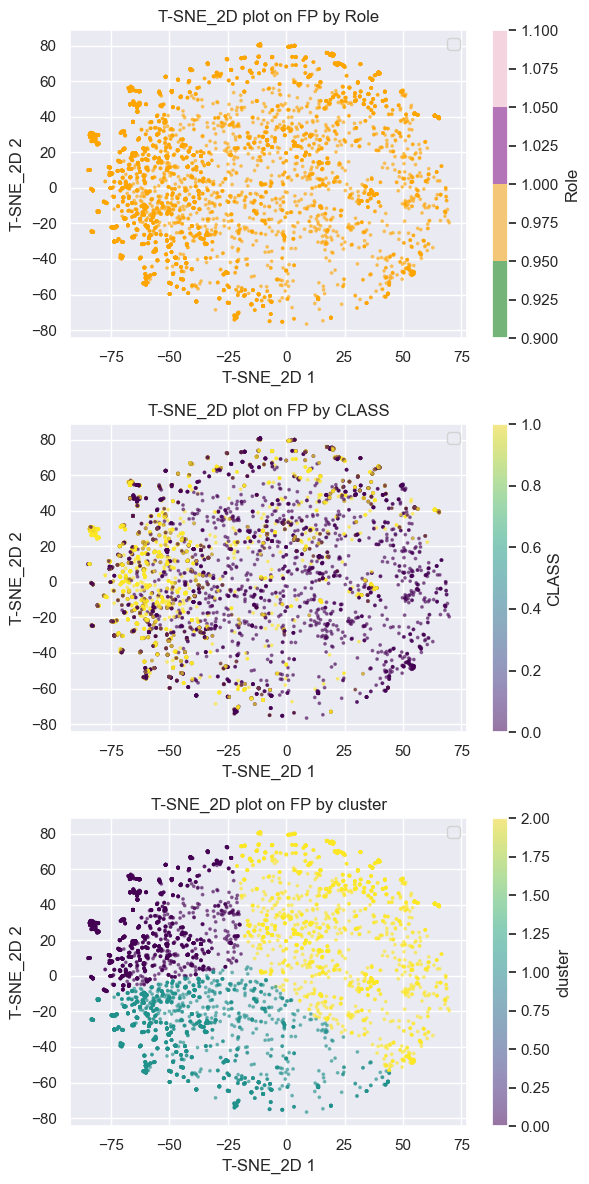

In [23]:
### knn clustering on FPs

import numpy as np
from sklearn.cluster import KMeans

# select plotting df of ROLE training
training_df = plotting_df[plotting_df["ROLE"] == "Training"]

# select FPs
feat = dim_reducers[0] + "_" + features[0]

data = np.stack(training_df[feat].to_numpy(), axis=0)

kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the KMeans model to the data
kmeans.fit(data)

# Get the cluster labels assigned to each data point
cluster_labels = kmeans.labels_

# Print the cluster labels and counts
print(dict(zip(np.unique(cluster_labels), np.bincount(cluster_labels))))

#append cluster labels to dataframe
training_df["cluster"] = cluster_labels


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


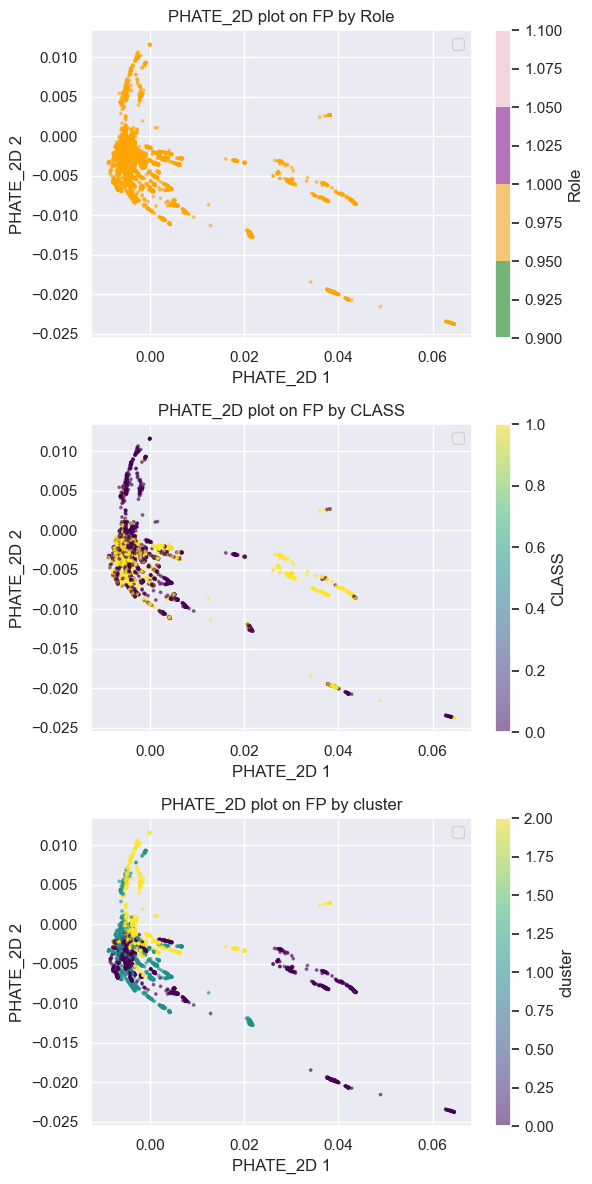

In [35]:

cnames = ["Role", "CLASS", "cluster"]
method = dim_reducers[1]
feature = "FP"

plot_scatter_grid(training_df, cnames, method, feature)


In [25]:
# select FP and CLASS columns
re_clustered_df = training_df[["FP", "CLASS", "cluster"]]

# calculate tanimoto similarity



# save to pkl file for each cluster
for i in range(3):
    cluster_df = re_clustered_df[re_clustered_df["cluster"] == i]
    # save to data dir
    cluster_df.to_pickle("data/cluster_"+str(i)+".pkl") 


In [28]:
cluster_settings = Settings()

cluster_settings.epochs_to_run = 200
# settings.generator_layer_sizes
# settings.use_feature_angle = True

cluster_settings.labeled_loss_multiplier = 50
cluster_settings.matching_loss_multiplier = 3
cluster_settings.contrasting_loss_multiplier = 2
cluster_settings.srgan_loss_multiplier = 125

cluster_settings.gradient_penalty_multiplier = 4750
k = 3
# train on each cluster separately - use the others as validation and test sets
numbers = [i for i in range(k)]*2

for i in range(k):
    cluster_settings.clean_datapath = "data/cluster_"+str(numbers[i])+".pkl"
    cluster_settings.validation_datapath = "data/cluster_"+str(numbers[i+1])+".pkl"
    cluster_settings.test_datapath = "data/cluster_"+str(numbers[i+2])+".pkl"

    cross_validation_experiment = DomAdpQSARSRGAN(cluster_settings)
    cross_validation_experiment.settings.trial_name = "SR GAN Ax LLx50 clean cluster "+str(i)+" Feat size 32 Ang False Norm feat Norm True Tanimoto"
    cross_validation_experiment.dataset_setup()
    #print the lengths of the dataframes
    print(len(cross_validation_experiment.clean_dataframe))
    print(len(cross_validation_experiment.validation_dataframe))
    print(len(cross_validation_experiment.test_dataframe))    
    cross_validation_experiment.set_rank("Tanimoto")
    cross_validation_experiment.train()



dataset rank:  None
3
2674
2645
2453
dataset rank:  Tanimoto


KeyError: 'Tanimoto'

/var/folders/4c/64jkr7n54w1558kqk0ks5rgr0000gn/T/ipykernel_1811/1159882587.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df["cluster"] = cluster_labels
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{0: 4179, 1: 3593}


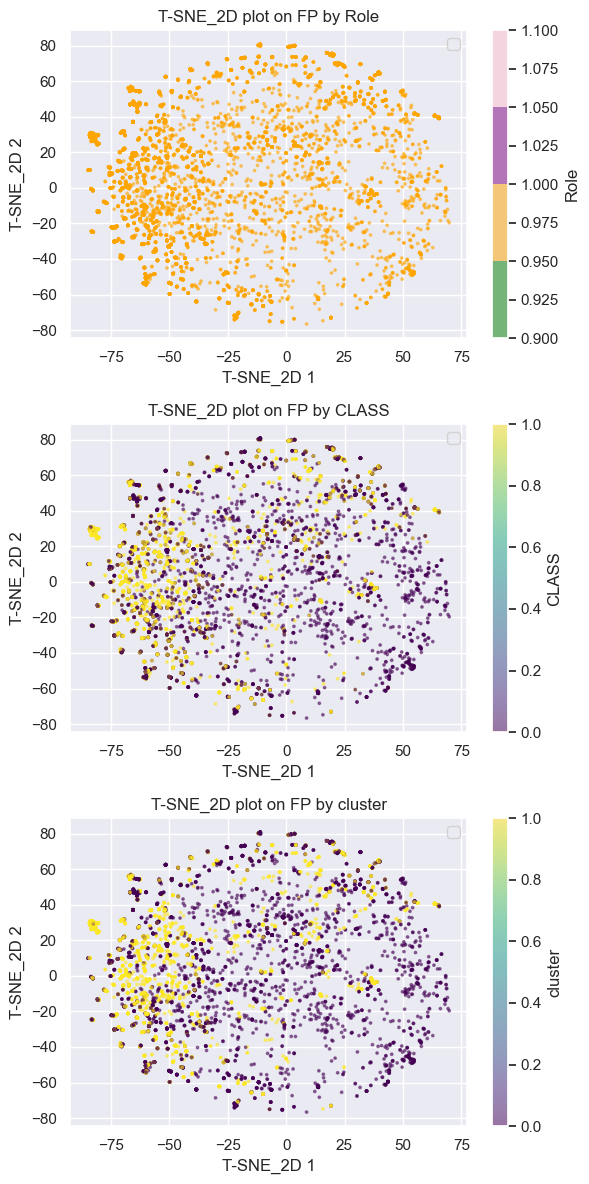

In [13]:
### knn clustering on FPs

import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# select plotting df of ROLE training
training_df = plotting_df[plotting_df["ROLE"] == "Training"]

# select FPs
feat = dim_reducers[0] + "_" + features[0]

data = np.stack(training_df[feat].to_numpy(), axis=0)

# Determine the value of k
k = 3

# Fit k-NN algorithm
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(data, training_df["CLASS"])

# Predict cluster labels
cluster_labels = knn.predict(data)
cluster_labels = cluster_labels.astype(int)

# Print the cluster labels and counts

print(dict(zip(np.unique(cluster_labels), np.bincount(cluster_labels))))

#append cluster labels to dataframe
training_df["cluster"] = cluster_labels

cnames = ["Role", "CLASS", "cluster"]
method = dim_reducers[0]
feature = "FP"

plot_scatter_grid(training_df, cnames, method, feature)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

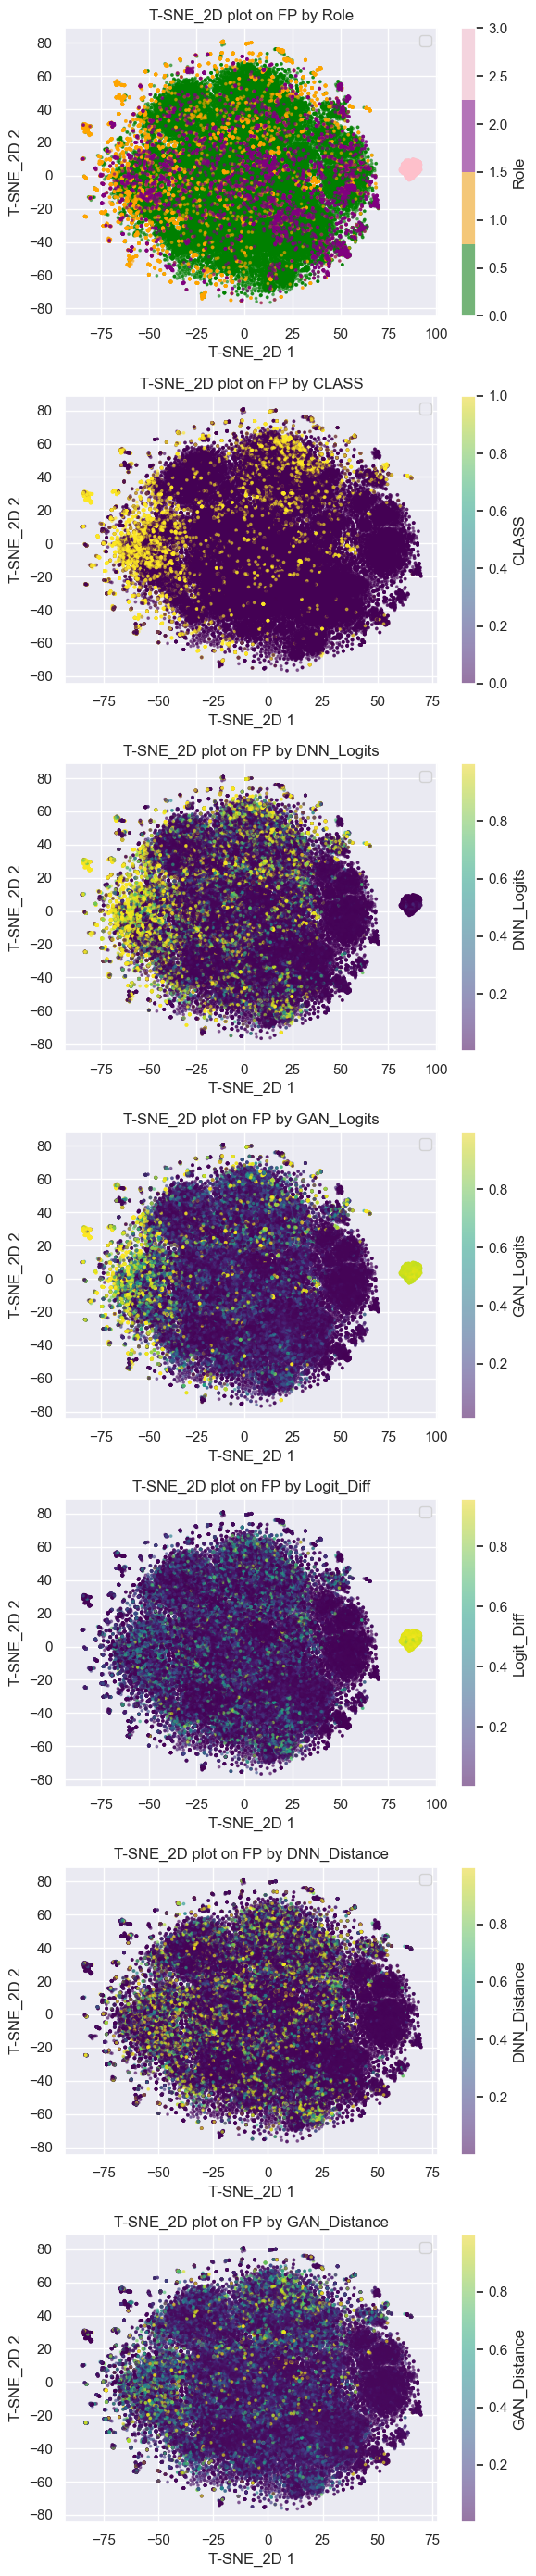

In [15]:
# Define the parameters
cnames = colour_indexes[:]
method = dim_reducers[0]
feature = features[0]

# Call the function to plot the scatter grid
plot_scatter_grid(plotting_df, cnames, method, feature)








No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

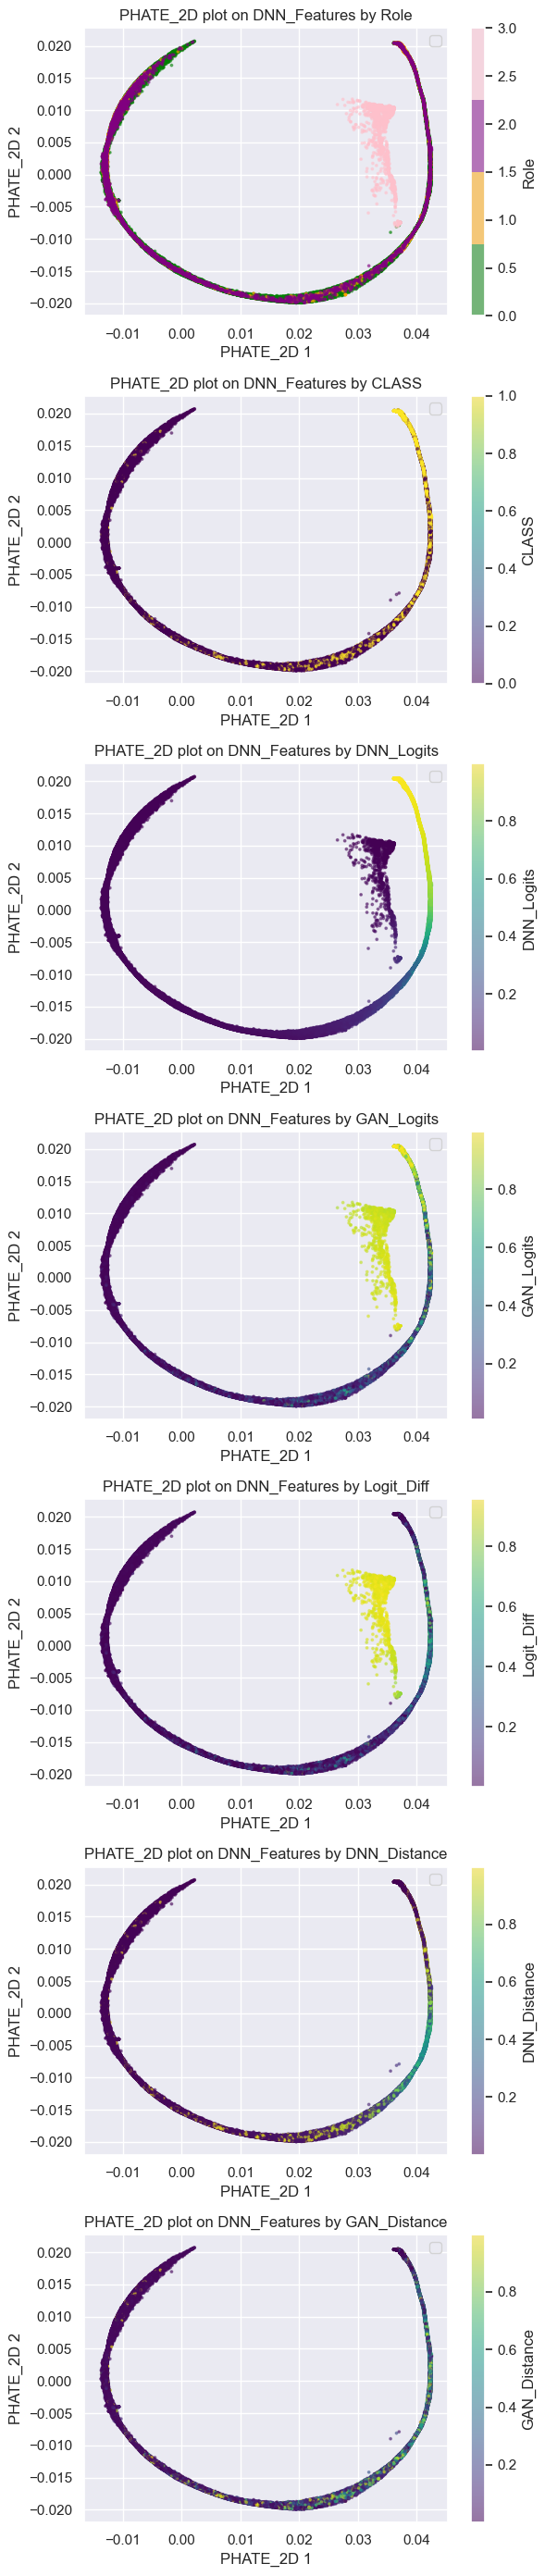

In [21]:
# Define the parameters
cnames = colour_indexes[:]
method = dim_reducers[1]
feature = features[1]

# Call the function to plot the scatter grid
plot_scatter_grid(plotting_df, cnames, method, feature)







No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

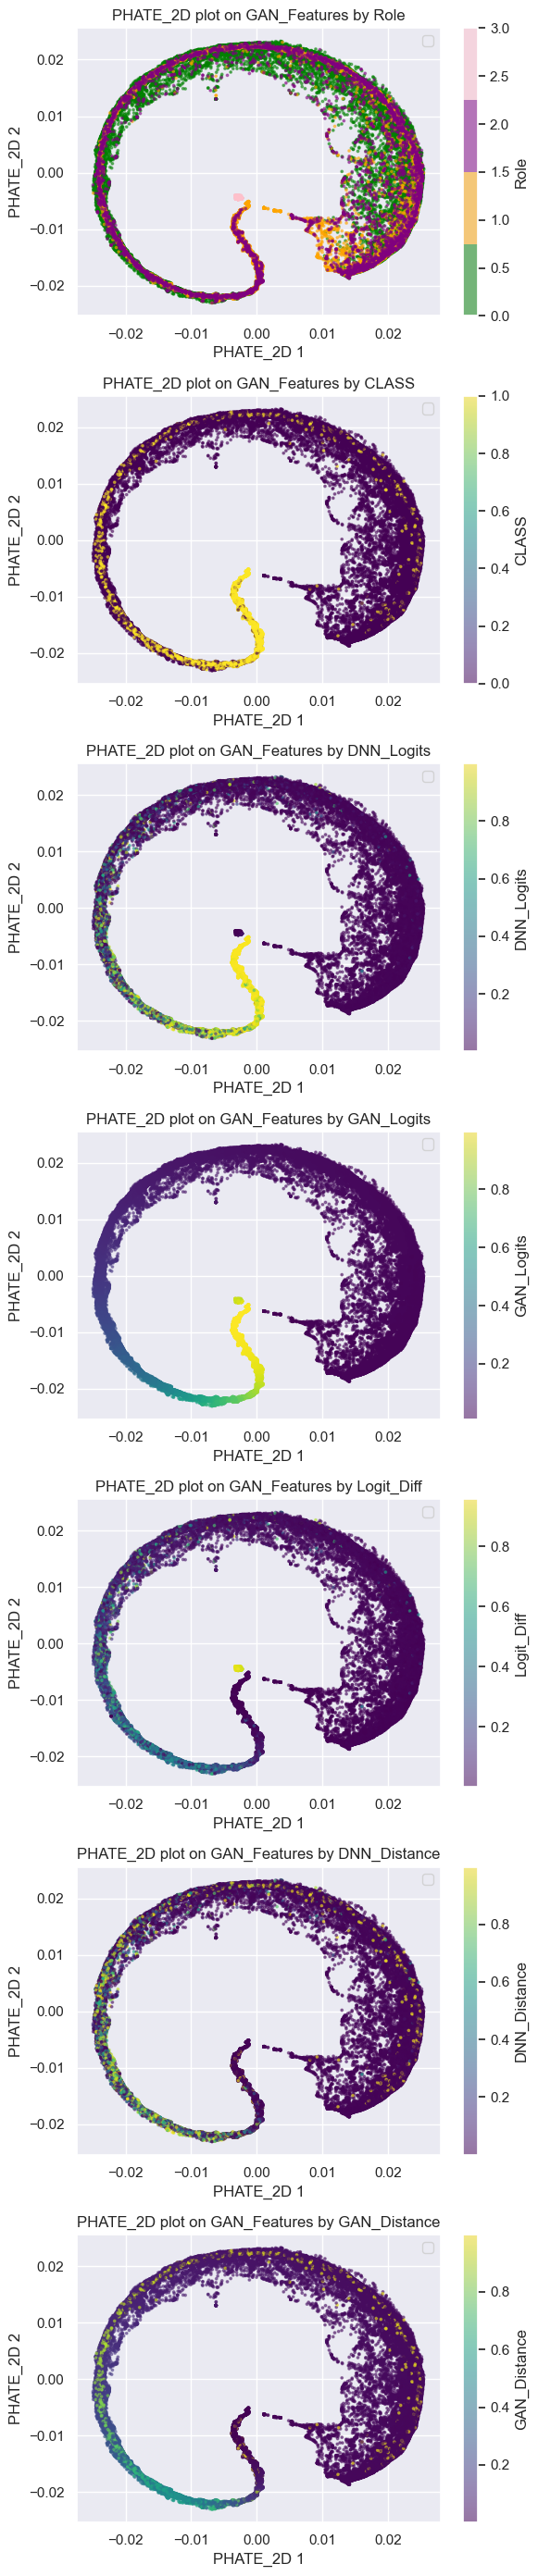

In [22]:
# Define the parameters
cnames = colour_indexes[:]
method = dim_reducers[1]
feature = features[2]

# Call the function to plot the scatter grid
plot_scatter_grid(plotting_df, cnames, method, feature)







No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


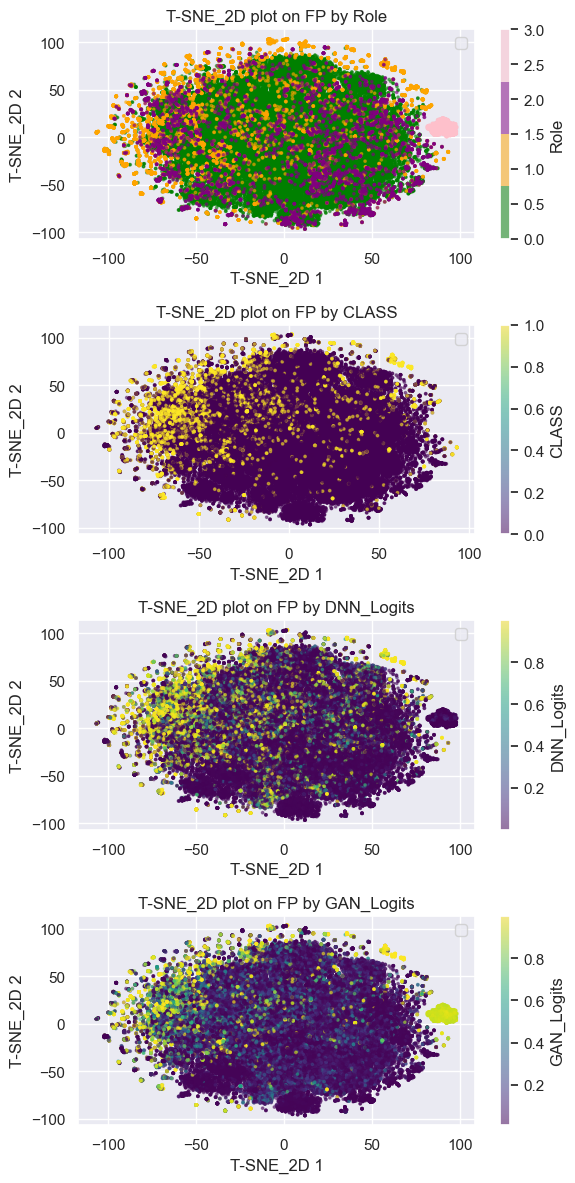

In [51]:
import matplotlib.pyplot as plt
import numpy as np



cnames = colour_indexes[:4]

method = dim_reducers[0]
feature = features[0]

fig, axs = plt.subplots(len(cnames), len([method]), figsize=(6*len([method]), 3*len(cnames)))

for i, cname in enumerate(cnames):
    ax = axs[i]
    if cname == "Role":
        cmap = matplotlib.colors.ListedColormap(colors)
    else:
        cmap = 'viridis'
    feature = features[0]  # Change this to the desired feature
    plot_scatter(ax, plotting_df, cname, cmap, method, feature)

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


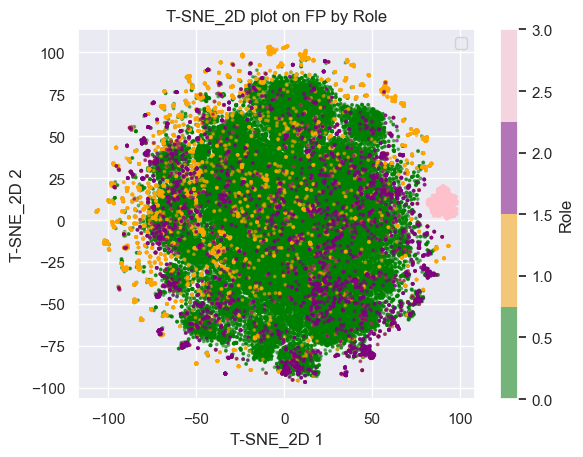

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


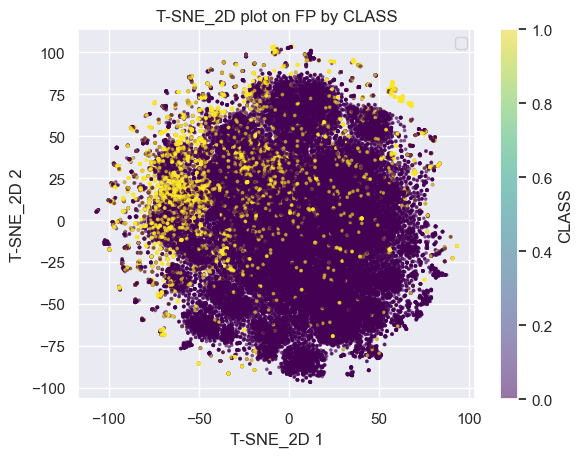

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


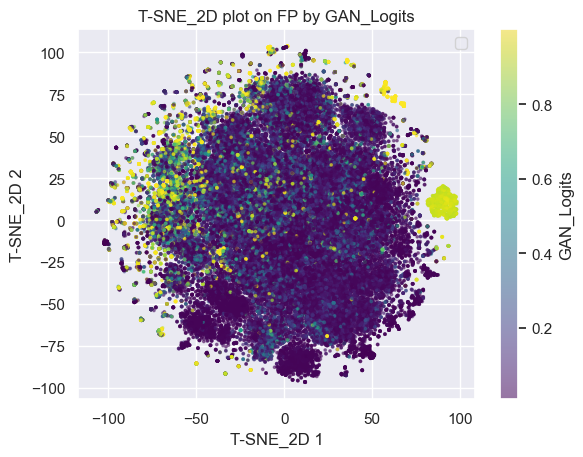

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


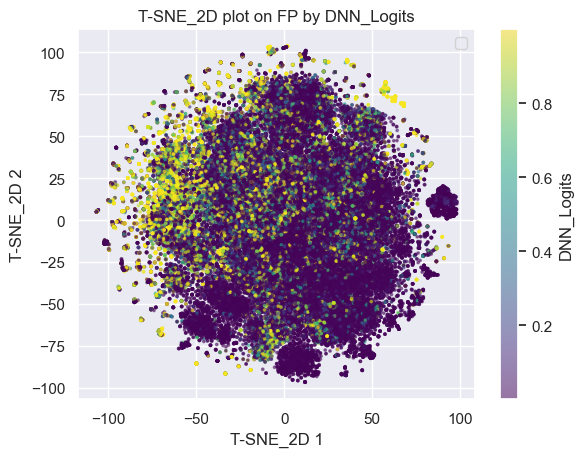

In [28]:
import matplotlib.pyplot as plt

cnames = ["Role", "CLASS", "GAN_Logits", "DNN_Logits"]

colors = ['green', 'orange', 'purple', 'pink']

features = ["FP", "DNN_Features", "GAN_Features"]
dim_reducers = ["T-SNE_2D", "PHATE_2D", "PHATE_3D"]

method = dim_reducers[0]
feature = features[0]

for cname in cnames:
    fig, ax = plt.subplots()
    if cname == "Role":
        cmap = matplotlib.colors.ListedColormap(colors)
    else:
        cmap = 'viridis'
    plot_scatter(ax, plotting_df, cname, cmap, method, feature)
    plt.show()







In [ ]:



# Plot based on "Role" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=plotting_df["Role"], cmap=matplotlib.colors.ListedColormap(colors), s=5, alpha=0.1)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (Role)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(colors)))
cbar.set_ticklabels(colors)

plt.show()

# Plot based on "CLASS" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=plotting_df["CLASS"], cmap='cool', s=5, alpha=0.1)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (CLASS)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLASS')

plt.show()

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=plotting_df["GAN_Logits"], cmap='cool', s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (GAN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GAN_Logits')

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=plotting_df["DNN_Logits"], cmap='cool', s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (DNN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('DNN_Logits')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


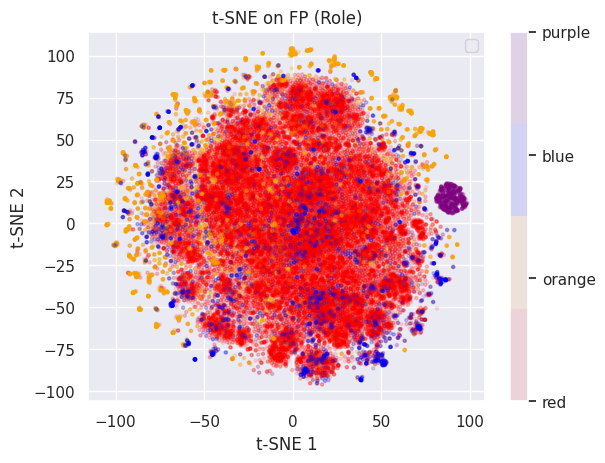

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


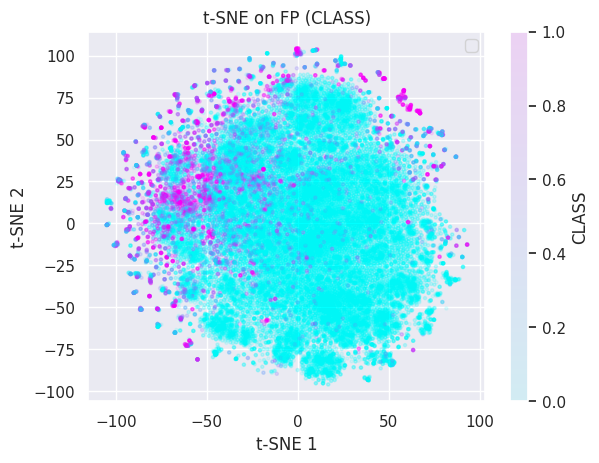

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


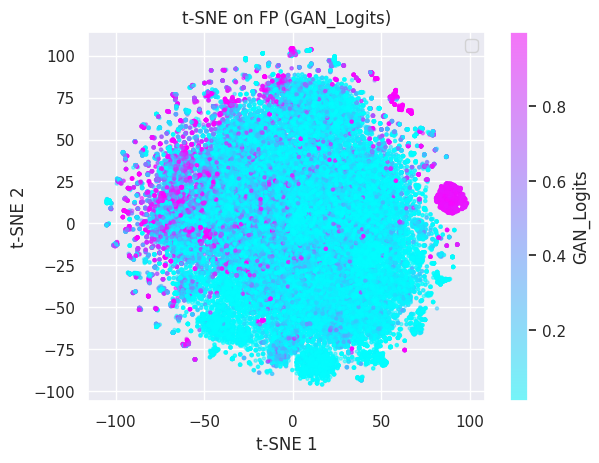

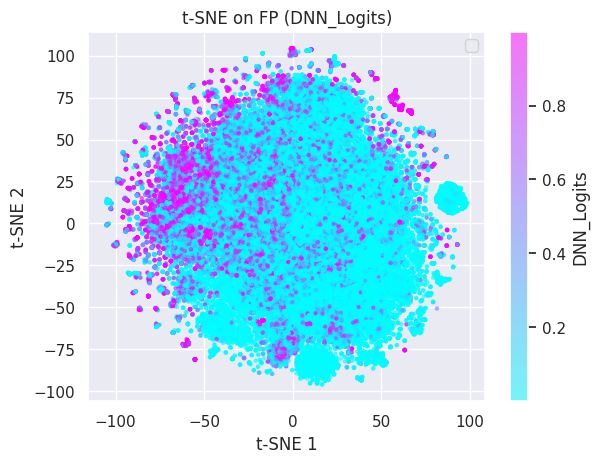

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on the GAN features
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
data = np.stack(global_df['FP'].to_numpy(), axis=0)

tsne_train = tsne.fit_transform(data)

colors = ['red', 'orange', 'blue', 'purple']

# Plot based on "Role" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["Role"], cmap=matplotlib.colors.ListedColormap(colors), s=5, alpha=0.1)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (Role)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(colors)))
cbar.set_ticklabels(colors)

plt.show()

# Plot based on "CLASS" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["CLASS"], cmap='cool', s=5, alpha=0.1)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (CLASS)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLASS')

plt.show()

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["GAN_Logits"], cmap='cool', s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (GAN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GAN_Logits')

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["DNN_Logits"], cmap='cool', s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on FP (DNN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('DNN_Logits')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


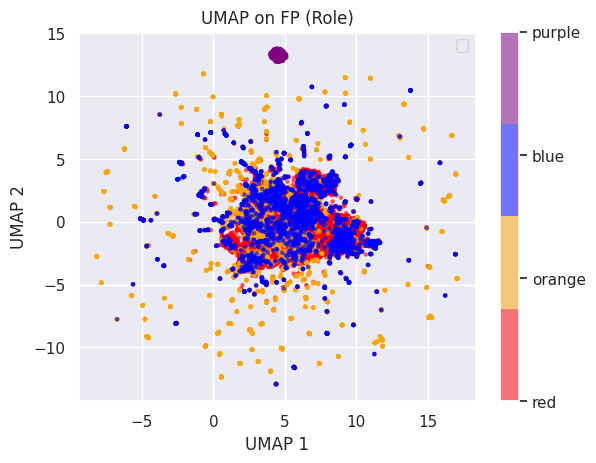

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


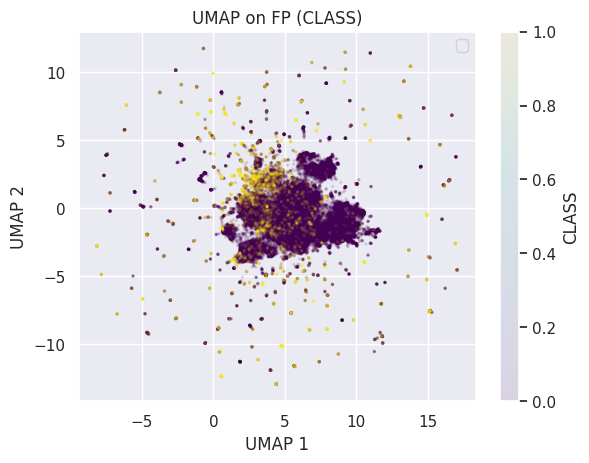

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


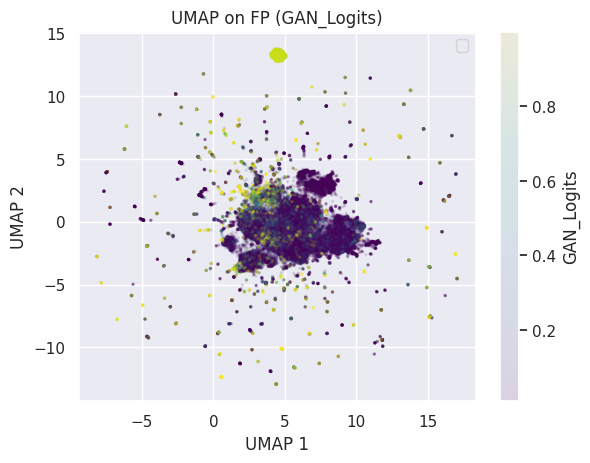

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


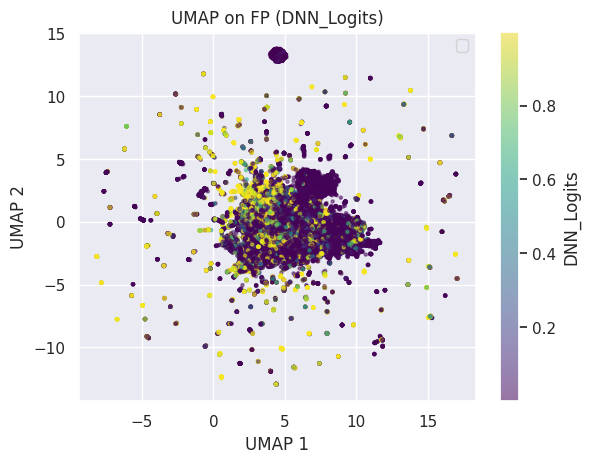

In [17]:
import matplotlib.pyplot as plt
import umap

# Perform UMAP on the GAN features
data = np.stack(global_df['FP'].to_numpy(), axis=0)

umap_embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(data)

colors = ['red', 'orange', 'blue', 'purple']

# Plot based on "Role" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["Role"], cmap=matplotlib.colors.ListedColormap(colors), s=5, alpha=0.5)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on FP (Role)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(colors)))
cbar.set_ticklabels(colors)

plt.show()

# Plot based on "CLASS" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["CLASS"], cmap='viridis', s=2, alpha=0.1)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on FP (CLASS)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLASS')

plt.show()

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["GAN_Logits"], cmap='viridis', s=2, alpha=0.1)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on FP (GAN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GAN_Logits')

plt.show()


# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["DNN_Logits"], cmap='viridis', s=5, alpha=0.5)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on FP (DNN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('DNN_Logits')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


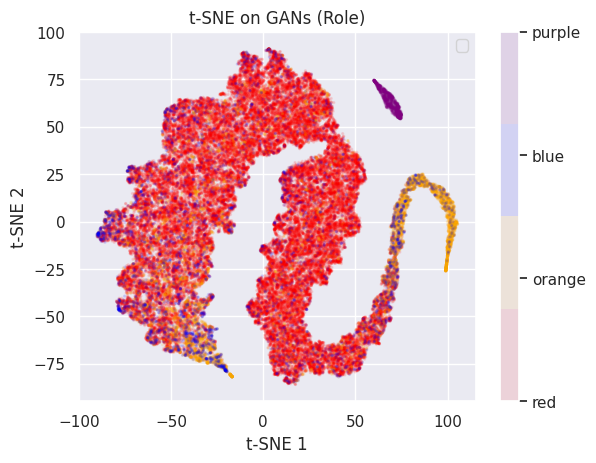

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


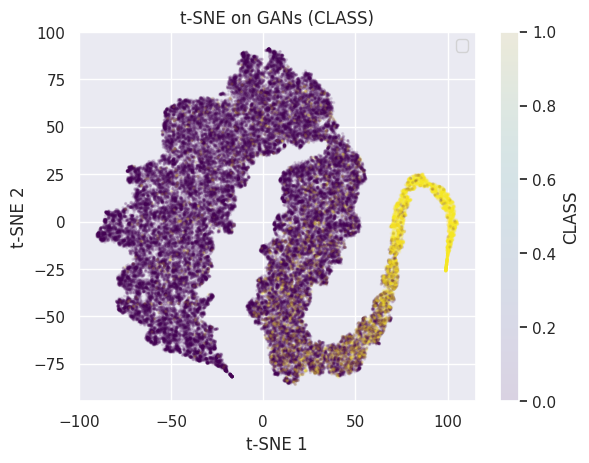

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


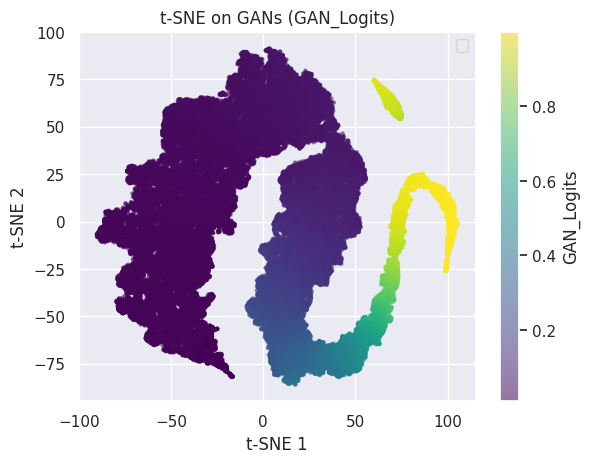

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on the GAN features
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
data = np.stack(global_df['GAN_Features'].to_numpy(), axis=0)

tsne_train = tsne.fit_transform(data)

colors = ['red', 'orange', 'blue', 'purple']

# Plot based on "Role" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["Role"], cmap=matplotlib.colors.ListedColormap(colors), s=2, alpha=0.1)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on GANs (Role)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(colors)))
cbar.set_ticklabels(colors)

plt.show()

# Plot based on "CLASS" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["CLASS"], cmap='viridis', s=2, alpha=0.1)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on GANs (CLASS)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLASS')

plt.show()

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["GAN_Logits"], cmap='viridis', s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on GANs (GAN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GAN_Logits')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


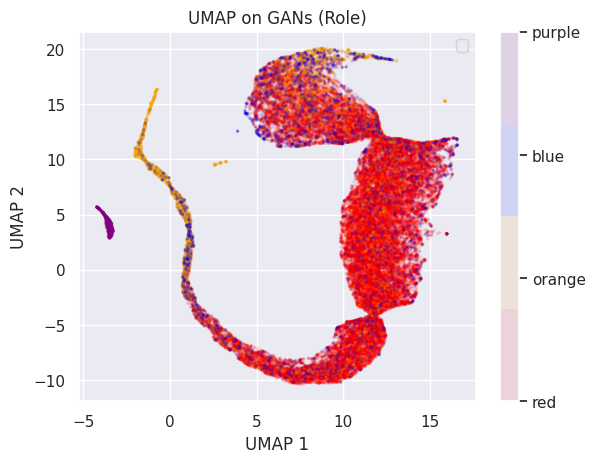

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


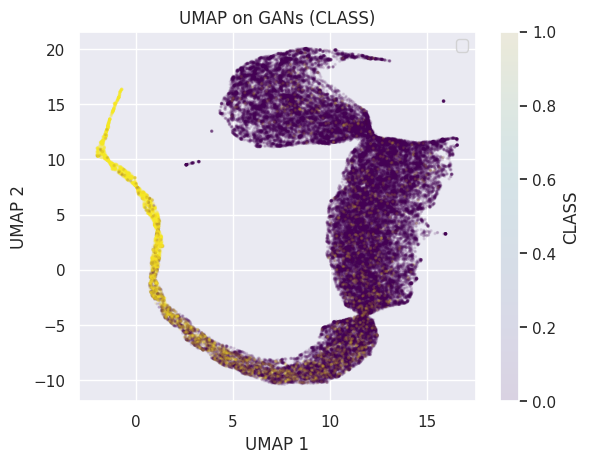

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


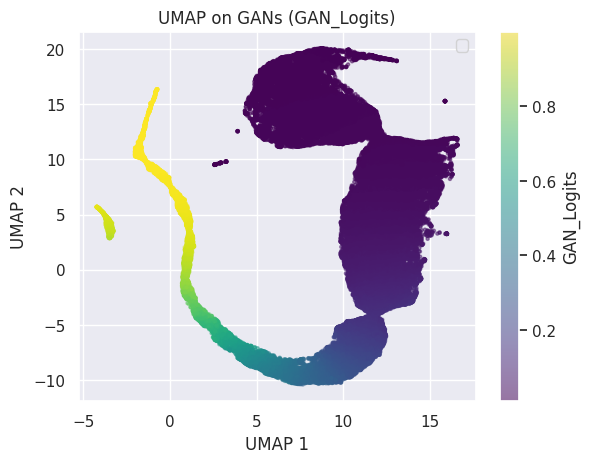

In [21]:
import matplotlib.pyplot as plt
import umap

# Perform UMAP on the GAN features
data = np.stack(global_df['GAN_Features'].to_numpy(), axis=0)

umap_embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(data)

colors = ['red', 'orange', 'blue', 'purple']

# Plot based on "Role" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["Role"], cmap=matplotlib.colors.ListedColormap(colors), s=2, alpha=0.1)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on GANs (Role)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(colors)))
cbar.set_ticklabels(colors)

plt.show()

# Plot based on "CLASS" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["CLASS"], cmap='viridis', s=2, alpha=0.1)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on GANs (CLASS)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLASS')

plt.show()

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["GAN_Logits"], cmap='viridis', s=5, alpha=0.5)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on GANs (GAN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('GAN_Logits')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


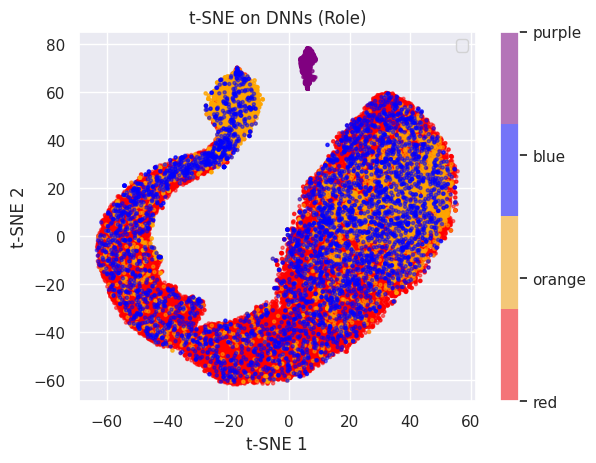

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


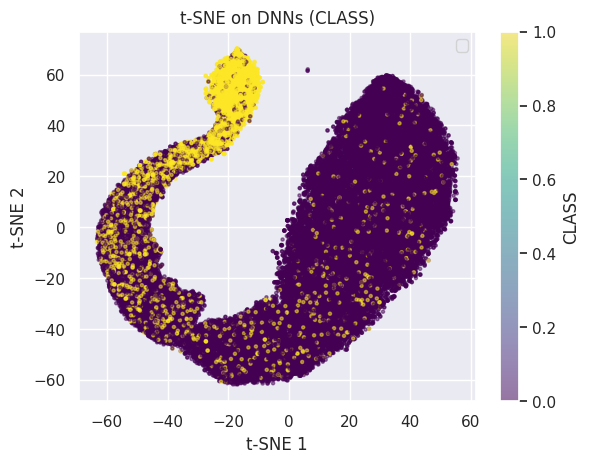

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


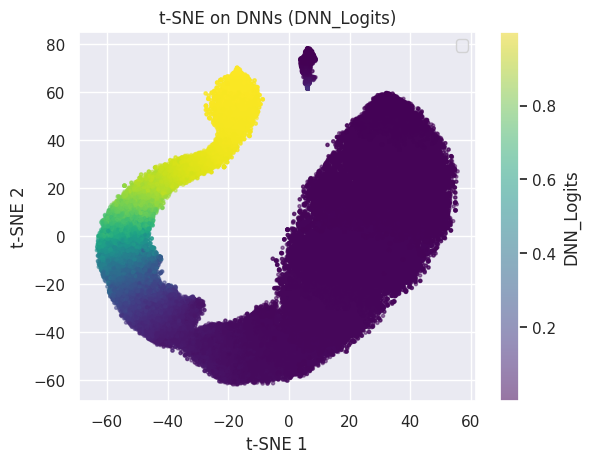

In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE on the GAN features
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
data = np.stack(global_df['DNN_Features'].to_numpy(), axis=0)

tsne_train = tsne.fit_transform(data)

colors = ['red', 'orange', 'blue', 'purple']

# Plot based on "Role" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["Role"], cmap=matplotlib.colors.ListedColormap(colors), s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on DNNs (Role)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(colors)))
cbar.set_ticklabels(colors)

plt.show()

# Plot based on "CLASS" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["CLASS"], cmap='viridis', s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on DNNs (CLASS)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLASS')

plt.show()

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_train[:, 0], tsne_train[:, 1], c=global_df["DNN_Logits"], cmap='viridis', s=5, alpha=0.5)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE on DNNs (DNN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('DNN_Logits')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


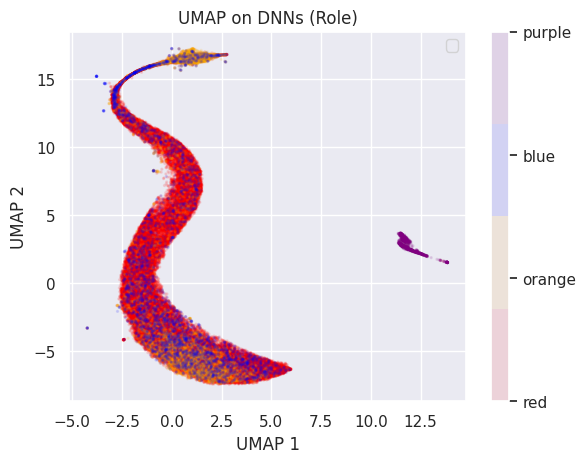

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


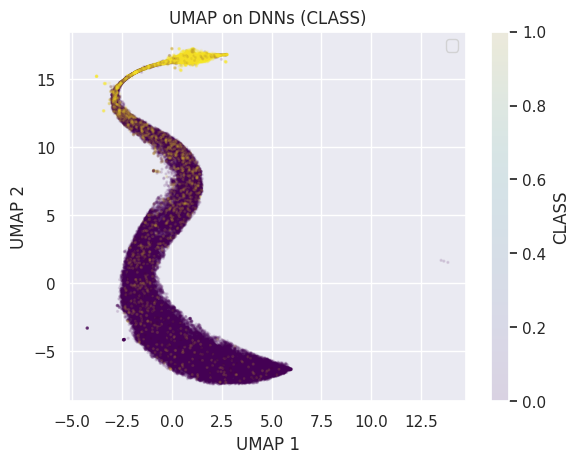

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


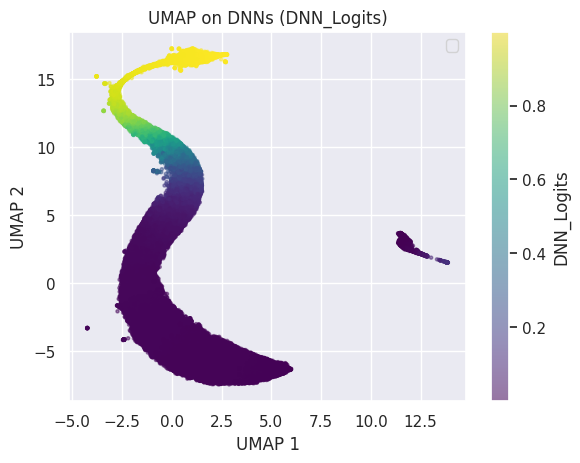

In [19]:
import matplotlib.pyplot as plt
import umap

# Perform UMAP on the GAN features
data = np.stack(global_df['DNN_Features'].to_numpy(), axis=0)

umap_embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(data)

colors = ['red', 'orange', 'blue', 'purple']

# Plot based on "Role" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["Role"], cmap=matplotlib.colors.ListedColormap(colors), s=2, alpha=0.1)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on DNNs (Role)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter, ticks=range(len(colors)))
cbar.set_ticklabels(colors)

plt.show()

# Plot based on "CLASS" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["CLASS"], cmap='viridis', s=2, alpha=0.1)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on DNNs (CLASS)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('CLASS')

plt.show()

# Plot based on "GAN_Logits" column
fig, ax = plt.subplots()
scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=global_df["DNN_Logits"], cmap='viridis', s=5, alpha=0.5)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP on DNNs (DNN_Logits)")
ax.legend()

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('DNN_Logits')

plt.show()
